In [44]:
#!pip install noisereduce

import os

import pandas as pd
import numpy as np

import librosa
import librosa.display

from IPython.display import Audio

from PIL import Image, ImageOps

from scipy.signal import butter, filtfilt

import matplotlib.cm as cm


In [3]:
audio_input_folder = "birdclef-2024/train_audio"
image_output_folder = "birdclef-2024/train_images"
meta_data = pd.read_csv("birdclef-2024/eBird_Taxonomy_v2021.csv")

The default hop_length is 512. For audio sampled at 22050 Hz, you get a feature frame rate of

frame_rate = sample_rate/hop_length = 22050 Hz/512 = 43 Hz
Again, padding may change this a little.

So for 10s of audio at 22050 Hz, you get a spectrogram array with the dimensions (128, 430), where 128 is the number of Mel bins and 430 the number of features (in this case, Mel spectra).'

In [4]:
#image height (width determined by length) - used for Mels value
image_height = 128

#processes up to this many audio files per species
max_seconds_audio_per_species = 1000

#going with a large number (can scale this down in training)
image_width_per_5_seconds = 512
hop_length = int(160400 / image_width_per_5_seconds)

target_frames = 256  # Desired number of frames

#bandpass filter for audio (Hz)
low_cut = 400
high_cut = 10000

In [5]:
def bird_species_from_folder(path):
    if path.endswith('/'):
        path = path[:-1]

    last_folder = os.path.basename(path)
    primary_com_name = meta_data.loc[meta_data['SPECIES_CODE'] == last_folder, 'PRIMARY_COM_NAME']
    primary_com_name_str = primary_com_name.iloc[0] if not primary_com_name.empty else ''    
    return f"{primary_com_name_str} ({last_folder})"

In [42]:
def bandpass_filter(data, lowcut, highcut, sr, order=5):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y



def spectrograms_for_audio(dirname, filename, preview=False):
    audio_path = os.path.join(dirname, filename)
    audio_data, sr = librosa.load(audio_path, sr=None)
    total_duration = librosa.get_duration(path=audio_path)
    
    audio_data = bandpass_filter(audio_data, low_cut, high_cut, sr)
    
    # Normalize the audio
    max_value = max(abs(audio_data))
    scaling_factor = 1.0 / max_value
    audio_data = audio_data * scaling_factor

    # Calculate hop length
    hop_length = int(total_duration * sr / target_frames)
    
    S = librosa.feature.melspectrogram(y=audio_data, sr=sr, hop_length=hop_length, n_mels=image_height, fmin=low_cut, fmax=high_cut)
    S_db = librosa.amplitude_to_db(S[:, :target_frames], ref=np.max)
    
    #print(S_db.shape)
    
    normalized_array = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))
    spectrogram_image = (normalized_array * 255).astype(np.uint8)  
    spectrogram_image = Image.fromarray(spectrogram_image)
    
    if preview == True:
        display(Audio(data=audio_data, rate=sr))
        spectrogram_image = cm.magma(normalized_array)[:, :, :3]
        spectrogram_image = (spectrogram_image * 255).astype(np.uint8) # (128, 313, 3) size
        spectrogram_image = Image.fromarray(spectrogram_image)
        #display(spectrogram_image)
        return spectrogram_image
    
    
    output_folder = os.path.join(image_output_folder, os.path.basename(os.path.normpath(dirname)))
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Naming files with an offset to indicate seconds offset
    base_filename = filename.replace('.ogg', '')
    output_filename = os.path.join(output_folder, f"{base_filename}.png")

    spectrogram_image.save(output_filename)

    return total_duration

In [33]:
total_duration = 36.048 

audio_duration = 5

int(total_duration // audio_duration)

7

In [32]:
int(160400 / image_width_per_5_seconds),  int(36.048 * 32000 / 313) # total_duration * sample HZ / hop_length

(313, 3685)

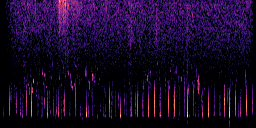

In [43]:
spectrograms_for_audio("birdclef-2024/train_audio/zitcis1/", "XC655341.ogg", preview=True)


In [14]:
# List everything in the audio input folder
entries = os.listdir(audio_input_folder)

# Filter to get only directories
subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(audio_input_folder, entry))]

# Sort the directories
subdirectories.sort()

folder_count = len(subdirectories)
folders_processed = 0


# Iterate through each sorted directory
for subdir in subdirectories:
    subdir_path = os.path.join(audio_input_folder, subdir)
    folders_processed += 1
    print("\n", bird_species_from_folder(subdir_path), folders_processed, "/", folder_count)

    # List files in the current directory (in any order)
    filenames = os.listdir(subdir_path)
    
    # Process up to max_audio_input_per_species files
    seconds_audio_this_species = 0
    for filename in filenames:
        seconds_audio = spectrograms_for_audio(subdir_path, filename)
        seconds_audio_this_species += seconds_audio
        print(".", end = "")
    print (f"({seconds_audio_this_species} seconds audio processed)")


 Asian Brown Flycatcher (asbfly) 1 / 182
.........................................................................................................(4360.450562499999 seconds audio processed)

 Ashy Drongo (ashdro1) 2 / 182
.............................................................................................................(4670.025937499999 seconds audio processed)

 Ashy Prinia (ashpri1) 3 / 182
................................................................................................(3268.54625 seconds audio processed)

 Ashy Woodswallow (ashwoo2) 4 / 182
.............................................(1538.2993124999994 seconds audio processed)

 Asian Koel (asikoe2) 5 / 182
...................................................................................................................................................................................................................................................................................(10030.79853124999 seconds

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(14460.549749999993 seconds audio processed)

 Common Iora (comior1) 39 / 182
...........................................................................................................................................................................................................................(8343.086781250006 seconds audio processed)

 Common Kingfisher (comkin1) 40 / 182
........................................................................................................................

...................................................................(1365.2268125 seconds audio processed)

 Greater Coucal (grecou1) 65 / 182
...................................................................................................................................................................(5305.621781250004 seconds audio processed)

 Great Egret (greegr) 66 / 182
....................................................................................................................................................................................................................................................................................(5902.356156249997 seconds audio processed)

 Greater Flameback (grefla1) 67 / 182
..........................................................(1537.3983125000002 seconds audio processed)

 Great Hornbill (grehor1) 68 / 182
.....................................(1335.204875 seconds audio processed)

 Gray Junglefowl (grejun2) 69 / 182
.........

...........................................................................................................................................................................................................................................(8909.015281250002 seconds audio processed)

 Laughing Dove (laudov1) 102 / 182
.................................................................................................................(4046.752781249999 seconds audio processed)

 Large-billed Leaf Warbler (lblwar1) 103 / 182
..........................................................................................(3073.2074687500003 seconds audio processed)

 Lesser Yellownape (lesyel1) 104 / 182
......................(1093.07596875 seconds audio processed)

 Lesser Whistling-Duck (lewduc1) 105 / 182
.................................(946.9811562500001 seconds audio processed)

 Little Ringed Plover (lirplo) 106 / 182
................................................................................

....................................................................................................................................................................................................................................................................................................................................................................................................................................(15763.761187499997 seconds audio processed)

 Rosy Starling (rossta2) 145 / 182
............................................................(2953.75825 seconds audio processed)

 Rufous Babbler (rufbab3) 146 / 182
.................(605.0143125000001 seconds audio processed)

 Rufous Treepie (ruftre2) 147 / 182
...............................................................................................................................(4286.60825 seconds audio processed)

 Rufous Woodpecker (rufwoo2) 148 / 182
.................................................(1195.69875000